In [1]:
import sys
import os
sys.path.append("../")


In [2]:
from tqdm import tqdm
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
from diffusion_policy.gym_util.multistep_wrapper import MultiStepWrapper
from diffusion_policy.env.robomimic.robomimic_lowdim_wrapper import RobomimicLowdimWrapper
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils

In [3]:
def create_env(env_meta, obs_keys):
    ObsUtils.initialize_obs_modality_mapping_from_dict(
        {'low_dim': obs_keys})
    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=False,
        use_image_obs=True, 
    )
    return env

In [4]:
def create_disturbance_function(task_name):
    if task_name == "lift":
        def disturbance_function(object_pos_quat, speed):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    elif task_name == "square":
        def disturbance_function(object_pos_quat):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    else:
        def disturbance_function(object_pos_quat):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    
    return disturbance_function

In [5]:
task_name = "lift"
# task_name = "square"
# task_name = "can"
dataset_type = "ph"
dataset_path = f"../data/robomimic/datasets/{task_name}/{dataset_type}/low_dim_abs.hdf5"
dataset_path = os.path.expanduser(dataset_path)
env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path)

#Inlucde this since it is abs true
obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
env_meta['env_kwargs']['controller_configs']['control_delta'] = False
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

robomimic_env = create_env(
                    env_meta=env_meta, 
                    obs_keys=obs_keys
                )

disturance_function = create_disturbance_function(task_name)

render_hw = (128, 128)
env_n_obs_steps = 2
env_n_action_steps = 8
max_steps = 400
render_camera_name = 'agentview'
multistep_env = MultiStepWrapper(
                    RobomimicLowdimWrapper(
                        env=robomimic_env,
                        obs_keys=obs_keys,
                        init_state=None,
                        render_hw=render_hw,
                        render_camera_name=render_camera_name
                    ),
                    n_obs_steps=env_n_obs_steps,
                    n_action_steps=env_n_action_steps,
                    max_episode_steps=max_steps
                )

Created environment with name Lift
Action size is 7


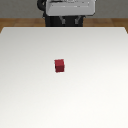

In [6]:
obs = multistep_env.reset()
state = multistep_env.env.env.get_state()

frame = multistep_env.render(mode='rgb_array')
img = Image.fromarray(frame)
img.save("test.png")
img.show()
object_pos_quat = state['states'][10:17] # x, y, z, qx, qy, qz, qw
robot0_gripper_qpos = state['states'][8:10]
robot_q_pos = state['states'][1:8]

In [7]:
print(object_pos_quat)

[-0.00737953 -0.02110393  0.83168553 -0.0627755   0.          0.
  0.99802767]


In [8]:
print(state['states'])

[ 0.00000000e+00  3.24002181e-02  2.08905065e-01  2.15780181e-02
 -2.60152952e+00 -1.22544494e-03  2.92303108e+00  8.15121581e-01
  2.08330000e-02 -2.08330000e-02 -7.37952608e-03 -2.11039308e-02
  8.31685527e-01 -6.27754956e-02  0.00000000e+00  0.00000000e+00
  9.98027674e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [9]:
multistep_env.env.env.get_observation()

{'object': array([-0.00737953, -0.02110393,  0.83168553,  0.        ,  0.        ,
         0.99802767, -0.0627755 , -0.09390666,  0.04678429,  0.17672308]),
 'robot0_eef_pos': array([-0.10128618,  0.02568036,  1.0084086 ]),
 'robot0_eef_quat': array([ 0.99833284,  0.01258339,  0.05615958, -0.00439391]),
 'robot0_gripper_qpos': array([ 0.020833, -0.020833])}

In [10]:
# object_pos_lst = list()

# for i in tqdm(range(100)):
#     multistep_env.reset()
#     state = multistep_env.env.env.get_state()
#     object_pos_quat = state['states'][10:13]
#     object_pos_lst.append(object_pos_quat)

# object_pos_lst = np.array(object_pos_lst)
# print(object_pos_lst.shape)



In [11]:
new_state = deepcopy(state)
# new_object_pos_quat = object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 1])
new_object_pos_quat = np.array([0.0, 0.0, 0.83, 1.0, 0, 0, 0])
# new_object_pos_quat = np.array([0.0, 0.0, 0.83, 1, 0, 0, 0])
new_state['states'][10:17] = new_object_pos_quat
multistep_env.env.env.reset_to(new_state)


{'object': array([ 0.        ,  0.        ,  0.83      ,  0.        ,  0.        ,
         0.        ,  1.        , -0.10128618,  0.02568036,  0.1784086 ]),
 'robot0_eef_pos': array([-0.10128618,  0.02568036,  1.0084086 ]),
 'robot0_eef_quat': array([ 0.99833284,  0.0125835 ,  0.05615958, -0.0043939 ]),
 'robot0_gripper_qpos': array([ 0.020833, -0.020833])}

[0.   0.   0.83 1.   0.   0.   0.  ]


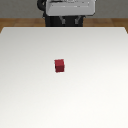

[0.   0.   0.83 1.   0.   0.   0.  ]


In [12]:
state = multistep_env.env.env.get_state()
print(state['states'][10:17])
frame = multistep_env.render(mode='rgb_array')
img.show()
img = Image.fromarray(frame)
img.save("test_new.png")
print(multistep_env.env.env.get_state()['states'][10:17])

[ 0.02101152 -0.02124917]


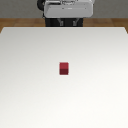

In [13]:
multistep_env.step(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.99,]]))
frame = multistep_env.render(mode='rgb_array')
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
img = Image.fromarray(frame)
img.show()


[ 0.02294302 -0.02318938]
[ 0.02294302 -0.02318938]


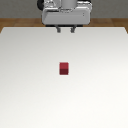

In [14]:
obs, reward, doen, info = multistep_env.step(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.99,]]))
frame = multistep_env.render(mode='rgb_array')
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
new_state = {k:v for k,v in deepcopy(state).items() if k != 'model'}
new_state['states'][10:17] = object_pos_quat + np.array([0.000, 0.0, 0.0, 0, 0, 0, 0])
multistep_env.env.env.reset_to(new_state)
print(state['states'][8:10])
img = Image.fromarray(frame)
img.show()


In [15]:
print(new_state.keys())

dict_keys(['states'])


In [16]:
state['states']

array([ 1.00000000e-01,  3.27963591e-02,  3.39926694e-01, -1.99163583e-02,
       -2.53534092e+00, -4.61836902e-02,  2.98259851e+00,  8.20628874e-01,
        2.29430163e-02, -2.31893792e-02,  3.41914447e-21,  3.13681789e-21,
        8.19442335e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.71548712e-02,  2.59922878e+00, -4.18183166e-01,
        1.60189032e+00, -6.11853981e-01,  8.11307951e-01,  1.54365456e-01,
        5.49114668e-02, -5.25866645e-02, -2.14283688e-22,  1.05666928e-20,
        2.98788677e-02,  1.56413539e-19,  3.64940068e-20,  7.96210171e-35])

In [17]:
multistep_env.reset()
print(multistep_env.env.env.get_observation())
print(multistep_env.env.env.get_state()['states'])

{'object': array([-0.01256155,  0.02897848,  0.8312825 ,  0.        ,  0.        ,
        0.87241507,  0.48876574, -0.09697708, -0.02379692,  0.17882964]), 'robot0_eef_pos': array([-0.10953863,  0.00518156,  1.01011213]), 'robot0_eef_quat': array([9.98678913e-01, 5.75051572e-03, 5.10608835e-02, 3.83953355e-04]), 'robot0_gripper_qpos': array([ 0.020833, -0.020833])}
[ 0.         -0.02272617  0.1870262   0.02944061 -2.6248114  -0.02771502
  2.9138418   0.80697594  0.020833   -0.020833   -0.01256155  0.02897848
  0.8312825   0.48876574  0.          0.          0.87241507  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [18]:
print(obs.shape)

(2, 19)


In [19]:
"Nut" in str(type(multistep_env.env.env.env))

False

In [ ]:
rewards = multistep_env.env.env.env.staged_rewards()
print(rewards)